In [19]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.tree import export_graphviz
from IPython.display import Image
#import graphviz

from ipynb.fs.full.UtilFunctions import format_season

In [23]:
dfs = []

In [24]:
for season in range(2017,2022):
    player_data = pd.read_csv("DataCollection/Player_Stats/player_stats_2021-22.csv")
    shooting_data = pd.read_csv("DataCollection/Player_Shooting_Stats/Regular_Season/player_shooting_stats_2021-22.csv")
    
    player_data = pd.merge(player_data, shooting_data.loc[:,~shooting_data.columns.isin(['Pos', 'Age', 'G', 'MP', 'FG%', "3PAr", "2P%", "3P%"])], on=['Player', 'Tm'])
    
    player_data = player_data.fillna(0)
    player_data = player_data[(player_data["MP"] > 15) & (player_data["G"] >= 30)]
    player_data = player_data.sort_values(by=['G'], ascending=False)
    player_data = player_data[player_data["Tm"] != "TOT"]
    player_data = player_data.drop_duplicates(subset ="Player",keep = "first")
    player_data.reset_index(inplace=True)
    player_data.drop(columns=['index'], inplace=True)
    
    dfs.append(player_data)

In [28]:
pd.set_option('display.max_columns', None)

In [34]:
df = dfs[0]
for i in range(1, len(dfs)):
    df = pd.concat([df, dfs[i]])
    
df.reset_index(inplace=True)
df.drop('index', axis=1, inplace=True)

In [35]:
features = df.loc[:, ~player_data.columns.isin(["Player", "Pos", "Tm"])]
target = df['Pos']

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size = 0.2)

In [38]:
rf = RandomForestClassifier()
rand_search = RandomizedSearchCV(rf, param_distributions = {'n_estimators': randint(50,500), 'max_depth': randint(1, 20)},
                                 n_iter = 5, cv = 5)
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028ADEADA160>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x0000028ADD99FDF0>})

In [39]:
best_rf = rand_search.best_estimator_
rand_search.best_params_

{'max_depth': 13, 'n_estimators': 240}

In [43]:
y_pred = best_rf.predict(X_test)

C:\Users\140775\Anaconda3\lib\site-packages\sklearn\utils\validation.py:70: FutureWarning: Pass display_labels=['PG', 'SG', 'SF', 'PF', 'C'] as keyword args. From version 1.0 (renaming of 0.25) passing these as positional arguments will result in an error
  warnings.warn(f"Pass {args_msg} as keyword args. From version "


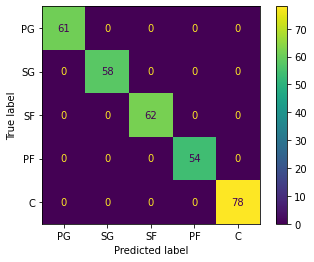

In [44]:
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm, ["PG", "SG", "SF", "PF", "C"]).plot()

In [45]:
accuracy = accuracy_score(y_test, y_pred)
accuracy

1.0

In [55]:
df.loc[52]['Pos']

'PF'

In [ ]:
for i in range(3):
    tree = rf.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)